# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


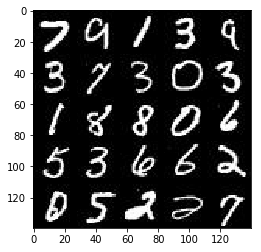

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

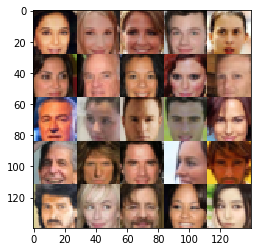

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.7)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=1, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, 0.7)
        # 14x14x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, 0.7)
        # 7x7x256
        
        x4 = tf.layers.conv2d(x3, 512, 5, strides=1, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha*x4, x4)
        x4 = tf.nn.dropout(x4, 0.7)
        # 7x7x512
        
        # Flatten
        flat = tf.reshape(x4, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*1024)
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.8)
        # 7x7x1024
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.8)
        # 7x7x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.8)
        # 14x14x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, 0.8)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
    
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, input_lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Resize images ( -1 to 1)
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                
                if steps % 10 == 0 or steps == 1:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0 or steps == 1:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        print("Done");
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 21.4988... Generator Loss: 0.0000


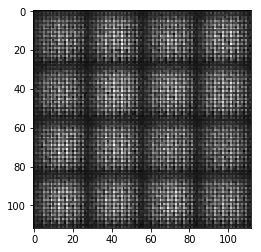

Epoch 1/2... Discriminator Loss: 1.0031... Generator Loss: 6.9645
Epoch 1/2... Discriminator Loss: 0.8076... Generator Loss: 5.5047
Epoch 1/2... Discriminator Loss: 1.5996... Generator Loss: 8.3685
Epoch 1/2... Discriminator Loss: 0.5771... Generator Loss: 4.1318
Epoch 1/2... Discriminator Loss: 3.7544... Generator Loss: 1.7732
Epoch 1/2... Discriminator Loss: 0.6588... Generator Loss: 2.8376
Epoch 1/2... Discriminator Loss: 3.1730... Generator Loss: 6.9220
Epoch 1/2... Discriminator Loss: 2.1470... Generator Loss: 1.3832
Epoch 1/2... Discriminator Loss: 0.7972... Generator Loss: 1.9590
Epoch 1/2... Discriminator Loss: 6.9378... Generator Loss: 9.6617


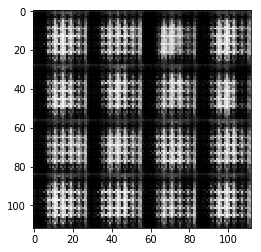

Epoch 1/2... Discriminator Loss: 0.8297... Generator Loss: 1.5236
Epoch 1/2... Discriminator Loss: 1.9055... Generator Loss: 4.4627
Epoch 1/2... Discriminator Loss: 3.7617... Generator Loss: 9.4839
Epoch 1/2... Discriminator Loss: 1.3082... Generator Loss: 0.9424
Epoch 1/2... Discriminator Loss: 3.4341... Generator Loss: 1.6641
Epoch 1/2... Discriminator Loss: 0.6115... Generator Loss: 2.9169
Epoch 1/2... Discriminator Loss: 2.5592... Generator Loss: 2.1736
Epoch 1/2... Discriminator Loss: 1.8110... Generator Loss: 1.2144
Epoch 1/2... Discriminator Loss: 0.8447... Generator Loss: 1.9600
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 2.5057


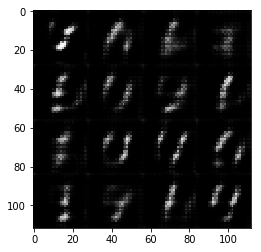

Epoch 1/2... Discriminator Loss: 2.1167... Generator Loss: 0.3529
Epoch 1/2... Discriminator Loss: 0.8240... Generator Loss: 2.2181
Epoch 1/2... Discriminator Loss: 3.7787... Generator Loss: 0.0687
Epoch 1/2... Discriminator Loss: 2.2897... Generator Loss: 2.6027
Epoch 1/2... Discriminator Loss: 1.3254... Generator Loss: 1.3290
Epoch 1/2... Discriminator Loss: 0.9476... Generator Loss: 1.6576
Epoch 1/2... Discriminator Loss: 1.4581... Generator Loss: 3.2375
Epoch 1/2... Discriminator Loss: 1.5454... Generator Loss: 1.8980
Epoch 1/2... Discriminator Loss: 1.3301... Generator Loss: 1.8097
Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 1.9813


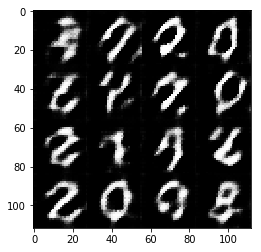

Epoch 1/2... Discriminator Loss: 2.1602... Generator Loss: 0.6519
Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 2.0490
Epoch 1/2... Discriminator Loss: 2.3353... Generator Loss: 0.2118
Epoch 1/2... Discriminator Loss: 1.8426... Generator Loss: 1.4810
Epoch 1/2... Discriminator Loss: 1.9829... Generator Loss: 1.4316
Epoch 1/2... Discriminator Loss: 1.8575... Generator Loss: 0.7287
Epoch 1/2... Discriminator Loss: 1.4486... Generator Loss: 1.0320
Epoch 1/2... Discriminator Loss: 1.6334... Generator Loss: 2.4605
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 1.4721
Epoch 1/2... Discriminator Loss: 1.0247... Generator Loss: 1.7625


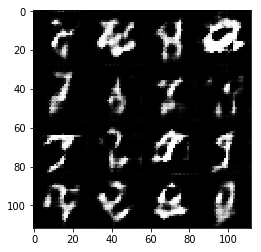

Epoch 1/2... Discriminator Loss: 2.1671... Generator Loss: 0.6510
Epoch 1/2... Discriminator Loss: 1.3285... Generator Loss: 1.0493
Epoch 1/2... Discriminator Loss: 1.9563... Generator Loss: 2.5413
Epoch 1/2... Discriminator Loss: 1.2645... Generator Loss: 0.8520
Epoch 1/2... Discriminator Loss: 0.9559... Generator Loss: 1.3236
Epoch 1/2... Discriminator Loss: 1.5087... Generator Loss: 0.6422
Epoch 1/2... Discriminator Loss: 2.0869... Generator Loss: 0.7118
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 2.7876
Epoch 1/2... Discriminator Loss: 2.2102... Generator Loss: 0.3807
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 2.2612


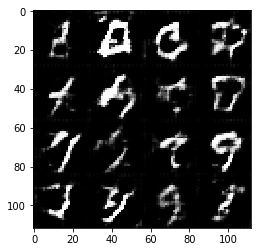

Epoch 1/2... Discriminator Loss: 3.3721... Generator Loss: 0.3277
Epoch 1/2... Discriminator Loss: 1.4459... Generator Loss: 2.0535
Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 2.5317
Epoch 1/2... Discriminator Loss: 1.5288... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 2.0383... Generator Loss: 0.8702
Epoch 1/2... Discriminator Loss: 3.0059... Generator Loss: 3.7656
Epoch 1/2... Discriminator Loss: 1.8934... Generator Loss: 2.4927
Epoch 1/2... Discriminator Loss: 1.1257... Generator Loss: 2.1633
Epoch 1/2... Discriminator Loss: 1.6868... Generator Loss: 0.4733
Epoch 1/2... Discriminator Loss: 1.9530... Generator Loss: 0.5763


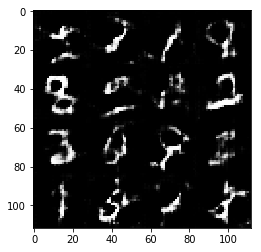

Epoch 1/2... Discriminator Loss: 1.2618... Generator Loss: 1.7204
Epoch 1/2... Discriminator Loss: 1.4775... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 0.9501... Generator Loss: 1.3380
Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 0.9187
Epoch 1/2... Discriminator Loss: 2.0792... Generator Loss: 1.3852
Epoch 1/2... Discriminator Loss: 1.3009... Generator Loss: 1.3510
Epoch 1/2... Discriminator Loss: 2.3804... Generator Loss: 0.4926
Epoch 1/2... Discriminator Loss: 1.7924... Generator Loss: 1.7242
Epoch 1/2... Discriminator Loss: 1.6402... Generator Loss: 2.1199
Epoch 1/2... Discriminator Loss: 2.5869... Generator Loss: 0.3023


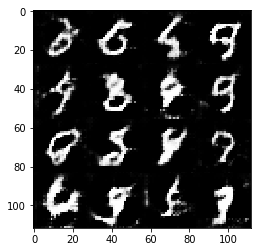

Epoch 1/2... Discriminator Loss: 1.5166... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 1.6814... Generator Loss: 2.0455
Epoch 1/2... Discriminator Loss: 1.9925... Generator Loss: 0.8034
Epoch 1/2... Discriminator Loss: 1.9220... Generator Loss: 0.8145
Epoch 1/2... Discriminator Loss: 1.2201... Generator Loss: 1.1028
Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 1.2435
Epoch 1/2... Discriminator Loss: 1.2538... Generator Loss: 1.9734
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 0.7510
Epoch 1/2... Discriminator Loss: 1.5834... Generator Loss: 1.6714
Epoch 1/2... Discriminator Loss: 1.9054... Generator Loss: 2.7645


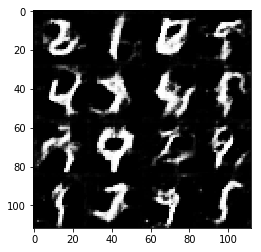

Epoch 1/2... Discriminator Loss: 1.5354... Generator Loss: 1.1639
Epoch 1/2... Discriminator Loss: 2.0087... Generator Loss: 0.4152
Epoch 1/2... Discriminator Loss: 2.0352... Generator Loss: 1.2523
Epoch 1/2... Discriminator Loss: 1.2589... Generator Loss: 1.1878
Epoch 1/2... Discriminator Loss: 1.1611... Generator Loss: 1.5095
Epoch 1/2... Discriminator Loss: 1.4938... Generator Loss: 1.9478
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.6827
Epoch 1/2... Discriminator Loss: 2.5314... Generator Loss: 0.4875
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 1.4823
Epoch 1/2... Discriminator Loss: 1.6636... Generator Loss: 0.9168


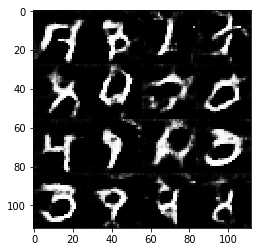

Epoch 1/2... Discriminator Loss: 1.1740... Generator Loss: 1.3915
Epoch 1/2... Discriminator Loss: 1.5540... Generator Loss: 0.4605
Epoch 1/2... Discriminator Loss: 1.0457... Generator Loss: 1.7539
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 1.6271
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 0.9278
Epoch 1/2... Discriminator Loss: 1.2652... Generator Loss: 1.2970
Epoch 1/2... Discriminator Loss: 1.7149... Generator Loss: 1.0401
Epoch 1/2... Discriminator Loss: 1.5124... Generator Loss: 0.8956
Epoch 1/2... Discriminator Loss: 1.4819... Generator Loss: 1.3144
Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 1.9198


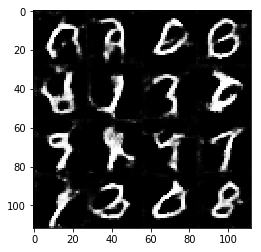

Epoch 1/2... Discriminator Loss: 0.9740... Generator Loss: 1.1199
Epoch 1/2... Discriminator Loss: 1.5173... Generator Loss: 2.2116
Epoch 1/2... Discriminator Loss: 1.0299... Generator Loss: 1.2786
Epoch 1/2... Discriminator Loss: 1.4566... Generator Loss: 1.0079
Epoch 1/2... Discriminator Loss: 1.7454... Generator Loss: 1.6181
Epoch 1/2... Discriminator Loss: 1.6770... Generator Loss: 0.9334
Epoch 1/2... Discriminator Loss: 1.4079... Generator Loss: 1.9295
Epoch 1/2... Discriminator Loss: 1.9265... Generator Loss: 2.7637
Epoch 1/2... Discriminator Loss: 1.0257... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 1.6145... Generator Loss: 0.6081


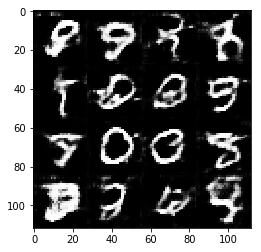

Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 1.7755
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.9096
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 1.5507
Epoch 1/2... Discriminator Loss: 1.6306... Generator Loss: 1.9304
Epoch 1/2... Discriminator Loss: 0.9433... Generator Loss: 1.7063
Epoch 1/2... Discriminator Loss: 2.7496... Generator Loss: 0.2370
Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 0.9859
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 1.4005
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 1.2977
Epoch 1/2... Discriminator Loss: 1.1233... Generator Loss: 1.3270


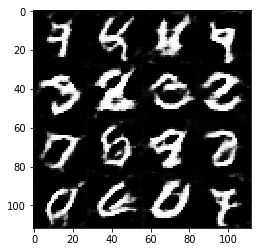

Epoch 1/2... Discriminator Loss: 1.5099... Generator Loss: 1.2528
Epoch 1/2... Discriminator Loss: 1.9201... Generator Loss: 0.9081
Epoch 1/2... Discriminator Loss: 1.7939... Generator Loss: 0.7555
Epoch 1/2... Discriminator Loss: 1.5005... Generator Loss: 0.7096
Epoch 1/2... Discriminator Loss: 1.0484... Generator Loss: 1.2231
Epoch 1/2... Discriminator Loss: 1.9509... Generator Loss: 0.4762
Epoch 1/2... Discriminator Loss: 1.2373... Generator Loss: 1.0609
Epoch 1/2... Discriminator Loss: 1.6683... Generator Loss: 1.5542
Epoch 1/2... Discriminator Loss: 1.4923... Generator Loss: 0.7023
Epoch 1/2... Discriminator Loss: 1.9450... Generator Loss: 0.9887


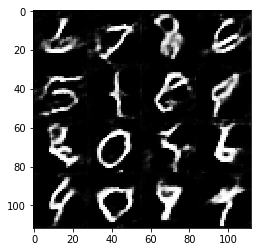

Epoch 1/2... Discriminator Loss: 1.4553... Generator Loss: 1.0404
Epoch 1/2... Discriminator Loss: 1.4590... Generator Loss: 1.1938
Epoch 1/2... Discriminator Loss: 1.0620... Generator Loss: 0.8376
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 1.1421
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 1.0785
Epoch 1/2... Discriminator Loss: 1.7261... Generator Loss: 0.5190
Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 1.3419... Generator Loss: 1.2226
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 1.3711
Epoch 1/2... Discriminator Loss: 1.3096... Generator Loss: 1.2204


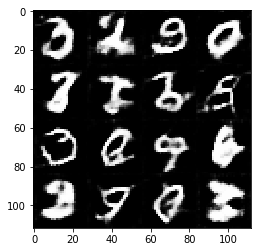

Epoch 1/2... Discriminator Loss: 1.7805... Generator Loss: 0.5462
Epoch 1/2... Discriminator Loss: 1.2965... Generator Loss: 1.6533
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 1.9492
Epoch 1/2... Discriminator Loss: 1.7413... Generator Loss: 0.6683
Epoch 1/2... Discriminator Loss: 1.5563... Generator Loss: 1.3118
Epoch 1/2... Discriminator Loss: 1.4681... Generator Loss: 1.6796
Epoch 1/2... Discriminator Loss: 1.7484... Generator Loss: 0.4782
Epoch 1/2... Discriminator Loss: 1.7110... Generator Loss: 0.3695
Epoch 1/2... Discriminator Loss: 1.5221... Generator Loss: 1.9084
Epoch 1/2... Discriminator Loss: 1.5411... Generator Loss: 0.7490


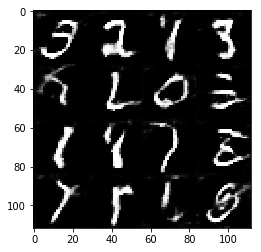

Epoch 1/2... Discriminator Loss: 1.4326... Generator Loss: 0.6944
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 1.1016
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 0.5200
Epoch 1/2... Discriminator Loss: 1.0648... Generator Loss: 1.4589
Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.7740
Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 1.2020
Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 0.9344
Epoch 1/2... Discriminator Loss: 1.3177... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.7529
Epoch 1/2... Discriminator Loss: 1.2630... Generator Loss: 1.4231


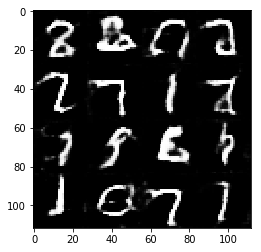

Epoch 1/2... Discriminator Loss: 1.1155... Generator Loss: 1.3851
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.6828
Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 1.4029
Epoch 1/2... Discriminator Loss: 1.6826... Generator Loss: 1.2245
Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 1.3626
Epoch 1/2... Discriminator Loss: 1.5935... Generator Loss: 1.6873
Epoch 1/2... Discriminator Loss: 1.4741... Generator Loss: 1.3454
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 1.4844
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 1.5284
Epoch 1/2... Discriminator Loss: 1.0871... Generator Loss: 1.0937


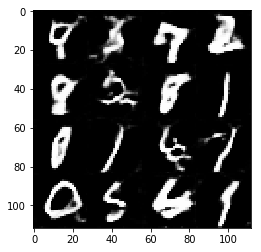

Epoch 1/2... Discriminator Loss: 1.7081... Generator Loss: 0.4524
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 0.8610
Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 1.2246
Epoch 1/2... Discriminator Loss: 0.8675... Generator Loss: 1.9923
Epoch 1/2... Discriminator Loss: 1.6797... Generator Loss: 0.3987
Epoch 1/2... Discriminator Loss: 1.1471... Generator Loss: 1.4409
Epoch 1/2... Discriminator Loss: 1.7416... Generator Loss: 0.6516
Epoch 1/2... Discriminator Loss: 1.1862... Generator Loss: 1.8513
Epoch 1/2... Discriminator Loss: 1.2700... Generator Loss: 0.6981
Epoch 1/2... Discriminator Loss: 1.4616... Generator Loss: 0.9378


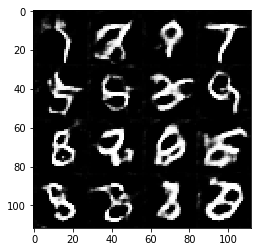

Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 1.6100
Epoch 1/2... Discriminator Loss: 1.8821... Generator Loss: 0.4372
Epoch 1/2... Discriminator Loss: 1.2963... Generator Loss: 1.4126
Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 0.9920
Epoch 1/2... Discriminator Loss: 1.4768... Generator Loss: 0.8141
Epoch 1/2... Discriminator Loss: 1.2248... Generator Loss: 1.0554
Epoch 1/2... Discriminator Loss: 1.1081... Generator Loss: 1.6805
Epoch 2/2... Discriminator Loss: 0.9855... Generator Loss: 1.8000
Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 1.7936
Epoch 2/2... Discriminator Loss: 0.8825... Generator Loss: 1.2343


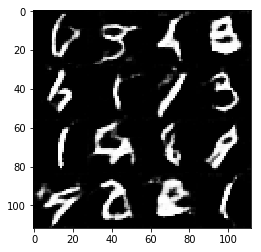

Epoch 2/2... Discriminator Loss: 1.0546... Generator Loss: 1.5260
Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 0.7881
Epoch 2/2... Discriminator Loss: 1.2008... Generator Loss: 1.9598
Epoch 2/2... Discriminator Loss: 0.9186... Generator Loss: 0.8222
Epoch 2/2... Discriminator Loss: 0.9628... Generator Loss: 1.3270
Epoch 2/2... Discriminator Loss: 0.9109... Generator Loss: 1.2729
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 2.0057
Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 1.8541
Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 0.8127
Epoch 2/2... Discriminator Loss: 0.8314... Generator Loss: 1.1932


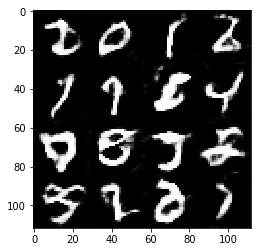

Epoch 2/2... Discriminator Loss: 1.0544... Generator Loss: 1.2734
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 1.5109
Epoch 2/2... Discriminator Loss: 1.1452... Generator Loss: 1.8315
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 1.3564
Epoch 2/2... Discriminator Loss: 1.2192... Generator Loss: 1.0148
Epoch 2/2... Discriminator Loss: 1.5894... Generator Loss: 0.8279
Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 1.5130
Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 1.4624
Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 1.0070
Epoch 2/2... Discriminator Loss: 0.7235... Generator Loss: 1.5743


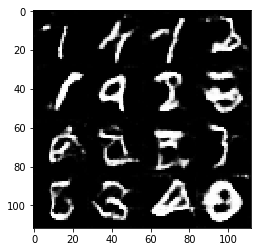

Epoch 2/2... Discriminator Loss: 1.0655... Generator Loss: 1.1750
Epoch 2/2... Discriminator Loss: 1.2425... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 0.8395... Generator Loss: 2.7150
Epoch 2/2... Discriminator Loss: 1.5022... Generator Loss: 1.4701
Epoch 2/2... Discriminator Loss: 0.7750... Generator Loss: 1.7473
Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 2.1364
Epoch 2/2... Discriminator Loss: 0.9371... Generator Loss: 1.9004
Epoch 2/2... Discriminator Loss: 1.1383... Generator Loss: 1.7701
Epoch 2/2... Discriminator Loss: 1.7853... Generator Loss: 2.8736
Epoch 2/2... Discriminator Loss: 0.8510... Generator Loss: 1.6788


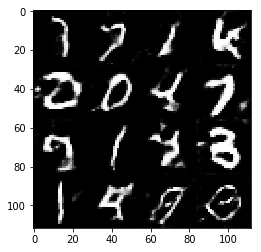

Epoch 2/2... Discriminator Loss: 1.4702... Generator Loss: 1.9194
Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 3.2039
Epoch 2/2... Discriminator Loss: 1.6576... Generator Loss: 0.6192
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 2.2528
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 2.9533
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.9132
Epoch 2/2... Discriminator Loss: 2.3677... Generator Loss: 0.5833
Epoch 2/2... Discriminator Loss: 1.4652... Generator Loss: 0.6621
Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 0.9500
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.7906


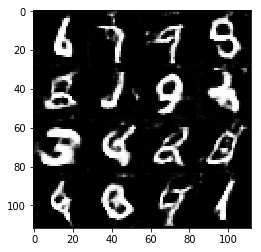

Epoch 2/2... Discriminator Loss: 1.3718... Generator Loss: 1.1340
Epoch 2/2... Discriminator Loss: 1.4081... Generator Loss: 0.6331
Epoch 2/2... Discriminator Loss: 1.5830... Generator Loss: 2.1478
Epoch 2/2... Discriminator Loss: 1.6577... Generator Loss: 0.3817
Epoch 2/2... Discriminator Loss: 1.8554... Generator Loss: 0.4384
Epoch 2/2... Discriminator Loss: 1.1840... Generator Loss: 1.5285
Epoch 2/2... Discriminator Loss: 1.1735... Generator Loss: 2.3707
Epoch 2/2... Discriminator Loss: 0.9542... Generator Loss: 1.7016
Epoch 2/2... Discriminator Loss: 1.5143... Generator Loss: 0.9065
Epoch 2/2... Discriminator Loss: 1.3034... Generator Loss: 1.4779


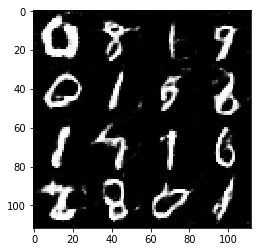

Epoch 2/2... Discriminator Loss: 1.8963... Generator Loss: 3.4951
Epoch 2/2... Discriminator Loss: 1.2201... Generator Loss: 1.7481
Epoch 2/2... Discriminator Loss: 1.4792... Generator Loss: 0.8499
Epoch 2/2... Discriminator Loss: 1.2459... Generator Loss: 1.4506
Epoch 2/2... Discriminator Loss: 1.1070... Generator Loss: 0.9641
Epoch 2/2... Discriminator Loss: 1.5058... Generator Loss: 0.5861
Epoch 2/2... Discriminator Loss: 1.1049... Generator Loss: 1.4615
Epoch 2/2... Discriminator Loss: 1.0762... Generator Loss: 1.4973
Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 1.1765
Epoch 2/2... Discriminator Loss: 1.1907... Generator Loss: 0.7222


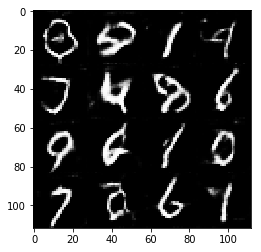

Epoch 2/2... Discriminator Loss: 1.2600... Generator Loss: 1.1448
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 1.5464
Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 1.1458
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 2.0093
Epoch 2/2... Discriminator Loss: 1.1904... Generator Loss: 1.3107
Epoch 2/2... Discriminator Loss: 1.5693... Generator Loss: 0.5757
Epoch 2/2... Discriminator Loss: 1.1966... Generator Loss: 1.4861
Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 1.4333
Epoch 2/2... Discriminator Loss: 1.0482... Generator Loss: 0.9170
Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 1.4605


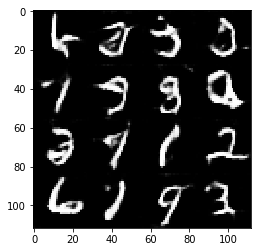

Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 1.9925
Epoch 2/2... Discriminator Loss: 1.2284... Generator Loss: 2.7464
Epoch 2/2... Discriminator Loss: 0.8378... Generator Loss: 1.5259
Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 1.7800
Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 2.3383
Epoch 2/2... Discriminator Loss: 1.1109... Generator Loss: 1.0440
Epoch 2/2... Discriminator Loss: 1.8377... Generator Loss: 1.4178
Epoch 2/2... Discriminator Loss: 0.7839... Generator Loss: 1.2683
Epoch 2/2... Discriminator Loss: 1.4587... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 0.7851... Generator Loss: 1.4592


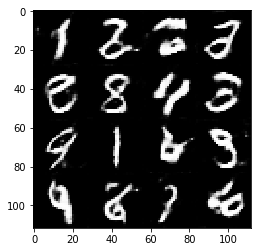

Epoch 2/2... Discriminator Loss: 1.4334... Generator Loss: 0.6041
Epoch 2/2... Discriminator Loss: 1.3642... Generator Loss: 0.7860
Epoch 2/2... Discriminator Loss: 0.9738... Generator Loss: 1.2437
Epoch 2/2... Discriminator Loss: 0.9259... Generator Loss: 2.0187
Epoch 2/2... Discriminator Loss: 1.0412... Generator Loss: 2.0980
Epoch 2/2... Discriminator Loss: 0.7658... Generator Loss: 2.4243
Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 1.4530
Epoch 2/2... Discriminator Loss: 1.0127... Generator Loss: 0.9122
Epoch 2/2... Discriminator Loss: 0.9010... Generator Loss: 1.3736
Epoch 2/2... Discriminator Loss: 0.8756... Generator Loss: 1.6121


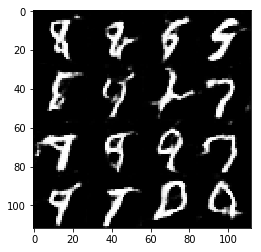

Epoch 2/2... Discriminator Loss: 2.7896... Generator Loss: 5.7036
Epoch 2/2... Discriminator Loss: 0.5667... Generator Loss: 2.8686
Epoch 2/2... Discriminator Loss: 0.9190... Generator Loss: 1.5316
Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 3.7583
Epoch 2/2... Discriminator Loss: 1.0758... Generator Loss: 2.4889
Epoch 2/2... Discriminator Loss: 1.2277... Generator Loss: 1.2861
Epoch 2/2... Discriminator Loss: 1.1071... Generator Loss: 1.2113
Epoch 2/2... Discriminator Loss: 0.8800... Generator Loss: 0.8785
Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 1.4797
Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 1.5023


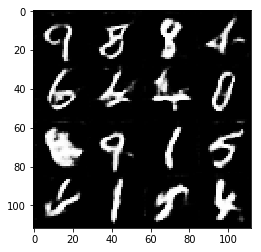

Epoch 2/2... Discriminator Loss: 1.6284... Generator Loss: 2.7766
Epoch 2/2... Discriminator Loss: 0.6418... Generator Loss: 1.7946
Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 1.8964
Epoch 2/2... Discriminator Loss: 0.6671... Generator Loss: 2.4378
Epoch 2/2... Discriminator Loss: 1.2762... Generator Loss: 1.1616
Epoch 2/2... Discriminator Loss: 0.9623... Generator Loss: 1.7142
Epoch 2/2... Discriminator Loss: 0.7129... Generator Loss: 2.5586
Epoch 2/2... Discriminator Loss: 1.4544... Generator Loss: 0.7179
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 1.8005
Epoch 2/2... Discriminator Loss: 1.0198... Generator Loss: 1.3350


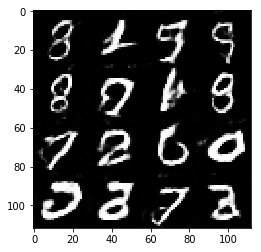

Epoch 2/2... Discriminator Loss: 0.9006... Generator Loss: 1.4570
Epoch 2/2... Discriminator Loss: 1.1272... Generator Loss: 3.4444
Epoch 2/2... Discriminator Loss: 0.8889... Generator Loss: 2.2442
Epoch 2/2... Discriminator Loss: 1.4826... Generator Loss: 1.6570
Epoch 2/2... Discriminator Loss: 0.8717... Generator Loss: 1.9694
Epoch 2/2... Discriminator Loss: 0.7648... Generator Loss: 1.7763
Epoch 2/2... Discriminator Loss: 1.2066... Generator Loss: 0.9151
Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 0.9133
Epoch 2/2... Discriminator Loss: 0.8713... Generator Loss: 2.7344
Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 2.1735


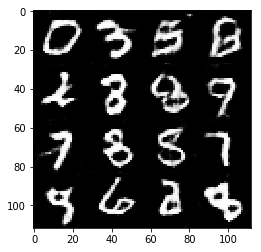

Epoch 2/2... Discriminator Loss: 1.0610... Generator Loss: 2.7754
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 1.2297
Epoch 2/2... Discriminator Loss: 1.5162... Generator Loss: 1.3824
Epoch 2/2... Discriminator Loss: 0.8725... Generator Loss: 1.4844
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.7688
Epoch 2/2... Discriminator Loss: 1.0886... Generator Loss: 1.3903
Epoch 2/2... Discriminator Loss: 1.1359... Generator Loss: 3.8110
Epoch 2/2... Discriminator Loss: 0.6376... Generator Loss: 2.0928
Epoch 2/2... Discriminator Loss: 1.6935... Generator Loss: 0.7049
Epoch 2/2... Discriminator Loss: 1.2431... Generator Loss: 1.5055


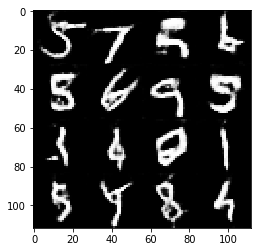

Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 1.8595
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 1.2435
Epoch 2/2... Discriminator Loss: 0.8360... Generator Loss: 1.5771
Epoch 2/2... Discriminator Loss: 0.7897... Generator Loss: 1.5396
Epoch 2/2... Discriminator Loss: 0.8885... Generator Loss: 1.3666
Epoch 2/2... Discriminator Loss: 0.7446... Generator Loss: 2.4944
Epoch 2/2... Discriminator Loss: 0.8361... Generator Loss: 1.3102
Epoch 2/2... Discriminator Loss: 1.1701... Generator Loss: 3.6957
Epoch 2/2... Discriminator Loss: 0.7957... Generator Loss: 1.9222
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 1.0454


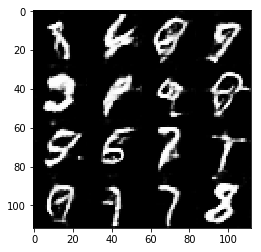

Epoch 2/2... Discriminator Loss: 2.2238... Generator Loss: 0.4510
Epoch 2/2... Discriminator Loss: 1.2905... Generator Loss: 3.3410
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.7872
Epoch 2/2... Discriminator Loss: 0.9695... Generator Loss: 0.9273
Epoch 2/2... Discriminator Loss: 0.7123... Generator Loss: 2.0193
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 3.2292
Epoch 2/2... Discriminator Loss: 1.4835... Generator Loss: 0.6012
Epoch 2/2... Discriminator Loss: 1.2003... Generator Loss: 1.2704
Epoch 2/2... Discriminator Loss: 0.6980... Generator Loss: 1.5179
Epoch 2/2... Discriminator Loss: 1.0965... Generator Loss: 0.9316


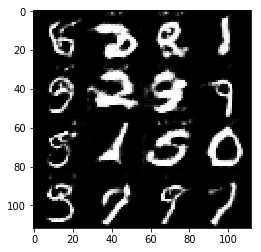

Epoch 2/2... Discriminator Loss: 1.6288... Generator Loss: 3.5204
Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 2.2286
Epoch 2/2... Discriminator Loss: 0.7775... Generator Loss: 2.2413
Epoch 2/2... Discriminator Loss: 1.0806... Generator Loss: 1.4216
Epoch 2/2... Discriminator Loss: 0.8984... Generator Loss: 1.2936
Epoch 2/2... Discriminator Loss: 1.4693... Generator Loss: 0.9635
Epoch 2/2... Discriminator Loss: 0.8396... Generator Loss: 1.8431
Epoch 2/2... Discriminator Loss: 1.5934... Generator Loss: 0.5955
Epoch 2/2... Discriminator Loss: 0.6096... Generator Loss: 2.3254
Epoch 2/2... Discriminator Loss: 0.9511... Generator Loss: 1.2668


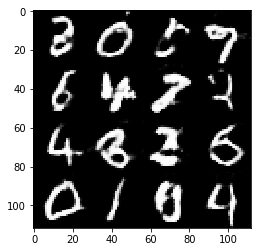

Epoch 2/2... Discriminator Loss: 1.1145... Generator Loss: 2.0487
Epoch 2/2... Discriminator Loss: 0.6920... Generator Loss: 1.5560
Epoch 2/2... Discriminator Loss: 1.0706... Generator Loss: 0.7178
Epoch 2/2... Discriminator Loss: 0.9290... Generator Loss: 1.5997
Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 1.0452
Epoch 2/2... Discriminator Loss: 0.7154... Generator Loss: 2.6423
Epoch 2/2... Discriminator Loss: 1.5832... Generator Loss: 1.1239
Epoch 2/2... Discriminator Loss: 0.9225... Generator Loss: 1.2802
Epoch 2/2... Discriminator Loss: 0.8612... Generator Loss: 1.7782
Epoch 2/2... Discriminator Loss: 1.1511... Generator Loss: 1.7073


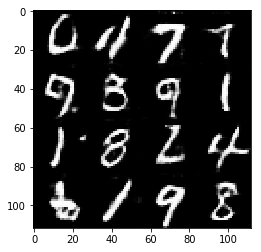

Epoch 2/2... Discriminator Loss: 0.7585... Generator Loss: 1.6716
Epoch 2/2... Discriminator Loss: 1.2423... Generator Loss: 1.5815
Epoch 2/2... Discriminator Loss: 0.8083... Generator Loss: 2.4110
Epoch 2/2... Discriminator Loss: 0.7044... Generator Loss: 1.7310
Epoch 2/2... Discriminator Loss: 0.5472... Generator Loss: 1.8089
Epoch 2/2... Discriminator Loss: 0.9757... Generator Loss: 1.8765
Epoch 2/2... Discriminator Loss: 2.0670... Generator Loss: 0.8914
Epoch 2/2... Discriminator Loss: 1.0348... Generator Loss: 1.8081
Epoch 2/2... Discriminator Loss: 0.7420... Generator Loss: 1.5037
Epoch 2/2... Discriminator Loss: 0.8787... Generator Loss: 3.4604


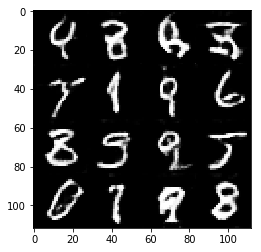

Epoch 2/2... Discriminator Loss: 0.8520... Generator Loss: 1.5689
Epoch 2/2... Discriminator Loss: 1.5175... Generator Loss: 0.8299
Epoch 2/2... Discriminator Loss: 0.8824... Generator Loss: 2.0709
Epoch 2/2... Discriminator Loss: 0.7047... Generator Loss: 1.8059
Epoch 2/2... Discriminator Loss: 0.7489... Generator Loss: 1.6373


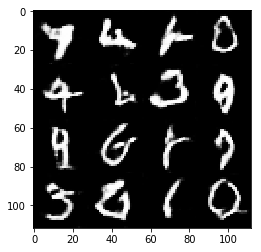

Done


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.8826... Generator Loss: 1.4683


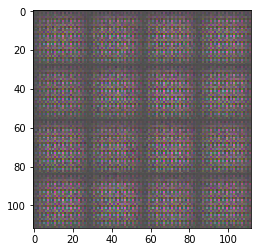

Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 7.7845
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 3.4542
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 2.2832
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 4.8644
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 4.3858
Epoch 1/1... Discriminator Loss: 5.0133... Generator Loss: 3.9533
Epoch 1/1... Discriminator Loss: 2.4000... Generator Loss: 1.7113
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 4.5351
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 2.1420
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 1.3352


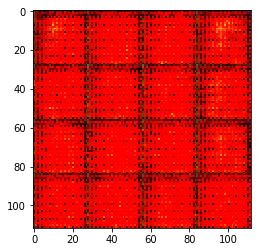

Epoch 1/1... Discriminator Loss: 1.6916... Generator Loss: 1.9721
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 2.8219
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 3.5931
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 5.7307
Epoch 1/1... Discriminator Loss: 4.6865... Generator Loss: 4.9293
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 4.8602
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 1.6301
Epoch 1/1... Discriminator Loss: 4.0441... Generator Loss: 7.9916
Epoch 1/1... Discriminator Loss: 1.6891... Generator Loss: 1.5808
Epoch 1/1... Discriminator Loss: 0.6916... Generator Loss: 2.1222


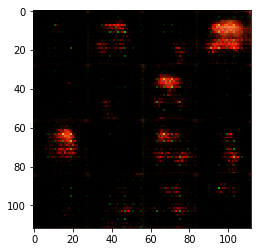

Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 3.3619
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 3.6941
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 5.7791
Epoch 1/1... Discriminator Loss: 2.1189... Generator Loss: 1.5419
Epoch 1/1... Discriminator Loss: 2.5834... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 3.1932
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.2823
Epoch 1/1... Discriminator Loss: 2.3097... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 1.6984
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 2.8158


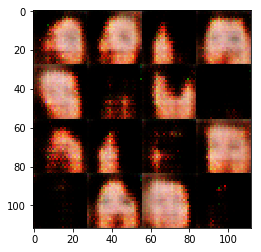

Epoch 1/1... Discriminator Loss: 1.9405... Generator Loss: 2.5248
Epoch 1/1... Discriminator Loss: 3.1251... Generator Loss: 3.0509
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 2.1514
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 3.3617
Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 0.3841
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 3.1497... Generator Loss: 0.2055
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 2.0149
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 2.1219
Epoch 1/1... Discriminator Loss: 1.6960... Generator Loss: 2.7169


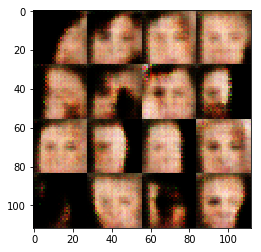

Epoch 1/1... Discriminator Loss: 2.7185... Generator Loss: 3.1384
Epoch 1/1... Discriminator Loss: 2.4521... Generator Loss: 4.4573
Epoch 1/1... Discriminator Loss: 0.7197... Generator Loss: 2.2263
Epoch 1/1... Discriminator Loss: 1.7999... Generator Loss: 2.9561
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.8298
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 2.5132
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 2.2268
Epoch 1/1... Discriminator Loss: 2.0505... Generator Loss: 3.2497
Epoch 1/1... Discriminator Loss: 2.6006... Generator Loss: 3.5030


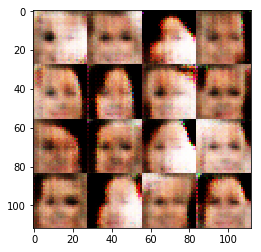

Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 2.0715
Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 2.7757
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 2.5047... Generator Loss: 0.3914
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 2.7849
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 2.0899
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 1.3912
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7232


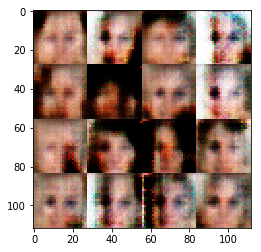

Epoch 1/1... Discriminator Loss: 2.0714... Generator Loss: 0.4335
Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 2.1917
Epoch 1/1... Discriminator Loss: 1.5454... Generator Loss: 1.1323
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 1.3216
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 1.4851
Epoch 1/1... Discriminator Loss: 2.0997... Generator Loss: 2.3238
Epoch 1/1... Discriminator Loss: 0.4725... Generator Loss: 3.2759
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 2.1407


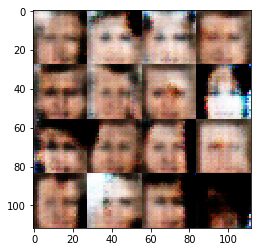

Epoch 1/1... Discriminator Loss: 2.4956... Generator Loss: 0.4961
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.7687
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 2.4088
Epoch 1/1... Discriminator Loss: 1.9416... Generator Loss: 1.1690
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 2.6708
Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 2.2402
Epoch 1/1... Discriminator Loss: 3.7728... Generator Loss: 0.1246
Epoch 1/1... Discriminator Loss: 1.7988... Generator Loss: 1.8231
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 0.7647... Generator Loss: 2.5110


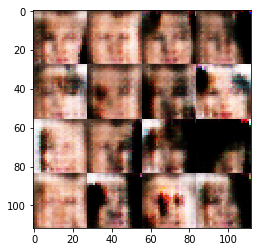

Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.9962
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 2.0558
Epoch 1/1... Discriminator Loss: 1.5506... Generator Loss: 4.8671
Epoch 1/1... Discriminator Loss: 0.5570... Generator Loss: 3.2734
Epoch 1/1... Discriminator Loss: 1.5506... Generator Loss: 2.2248
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 1.6162
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 1.9417
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 1.2698
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 1.7546


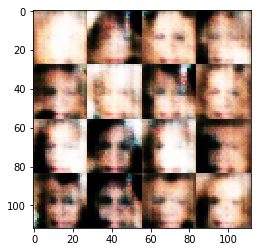

Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 3.3686
Epoch 1/1... Discriminator Loss: 0.7245... Generator Loss: 1.5250
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 1.1651
Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 2.5306
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 3.3784
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 1.2890
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 3.5499


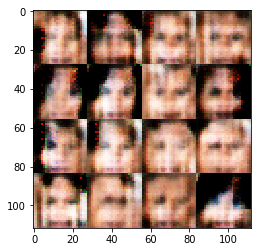

Epoch 1/1... Discriminator Loss: 1.9687... Generator Loss: 4.0570
Epoch 1/1... Discriminator Loss: 1.7001... Generator Loss: 2.9282
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.4973
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 2.7720... Generator Loss: 3.3936
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 1.6012
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.3400
Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 2.8980
Epoch 1/1... Discriminator Loss: 1.5759... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 2.7264


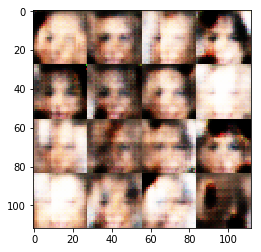

Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 1.3081
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 2.8329
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 2.3524
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 2.2416
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 1.6537
Epoch 1/1... Discriminator Loss: 0.6447... Generator Loss: 1.8517
Epoch 1/1... Discriminator Loss: 5.1240... Generator Loss: 5.1093
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.9871
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.4457


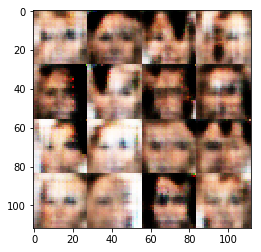

Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.9761
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.4101
Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 2.7465
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 2.1202
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 2.8255
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 3.6150
Epoch 1/1... Discriminator Loss: 0.5791... Generator Loss: 2.0372
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 1.5773


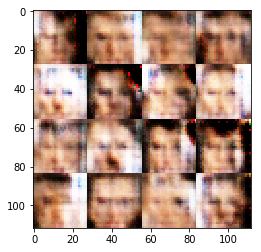

Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 1.1771
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 1.2873
Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 2.3755
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 1.8054
Epoch 1/1... Discriminator Loss: 3.0297... Generator Loss: 2.7613
Epoch 1/1... Discriminator Loss: 0.6731... Generator Loss: 1.4883
Epoch 1/1... Discriminator Loss: 0.5710... Generator Loss: 2.4241
Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 1.2871
Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 1.5948
Epoch 1/1... Discriminator Loss: 2.0991... Generator Loss: 0.3229


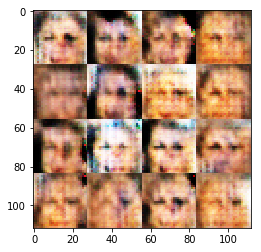

Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 1.1449
Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.7278
Epoch 1/1... Discriminator Loss: 0.5787... Generator Loss: 3.4901
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 2.0000
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 2.1028
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 1.4853
Epoch 1/1... Discriminator Loss: 1.5604... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 0.6695... Generator Loss: 2.4947


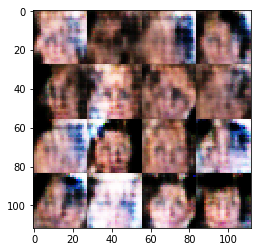

Epoch 1/1... Discriminator Loss: 0.5259... Generator Loss: 2.7005
Epoch 1/1... Discriminator Loss: 0.6143... Generator Loss: 1.4478
Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 3.7943
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.8848
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 2.0937
Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 0.4592... Generator Loss: 4.2565
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 3.1825
Epoch 1/1... Discriminator Loss: 2.3612... Generator Loss: 0.4504
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 1.2857


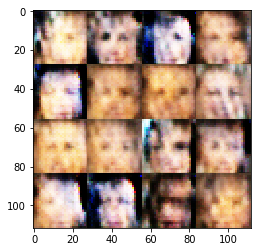

Epoch 1/1... Discriminator Loss: 0.8285... Generator Loss: 2.3919
Epoch 1/1... Discriminator Loss: 0.7829... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 1.9354
Epoch 1/1... Discriminator Loss: 2.5545... Generator Loss: 4.5359
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.7445
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 2.5046
Epoch 1/1... Discriminator Loss: 0.6961... Generator Loss: 1.6059
Epoch 1/1... Discriminator Loss: 0.5876... Generator Loss: 2.0482
Epoch 1/1... Discriminator Loss: 0.8381... Generator Loss: 3.3092


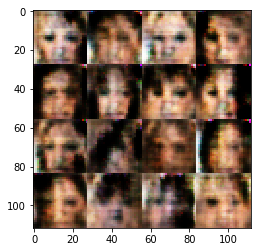

Epoch 1/1... Discriminator Loss: 0.6252... Generator Loss: 3.3484
Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 4.2485
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 1.0368
Epoch 1/1... Discriminator Loss: 0.5216... Generator Loss: 2.6523
Epoch 1/1... Discriminator Loss: 2.3244... Generator Loss: 0.2522
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.9451... Generator Loss: 0.3719
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.5524
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 2.6884
Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 1.9166


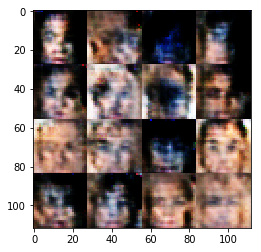

Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 2.9543
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 1.8236
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 2.9271
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 2.6656
Epoch 1/1... Discriminator Loss: 0.4440... Generator Loss: 4.4600
Epoch 1/1... Discriminator Loss: 1.6534... Generator Loss: 1.2489
Epoch 1/1... Discriminator Loss: 0.7297... Generator Loss: 2.9937
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 1.6567
Epoch 1/1... Discriminator Loss: 0.6687... Generator Loss: 1.7810


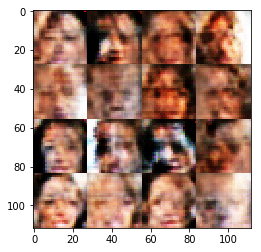

Epoch 1/1... Discriminator Loss: 1.8330... Generator Loss: 2.5628
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 1.9688
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 1.7030
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 1.2112
Epoch 1/1... Discriminator Loss: 0.7870... Generator Loss: 1.7581
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 2.0294
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 1.6737
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 1.9572
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 1.4157
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.0455


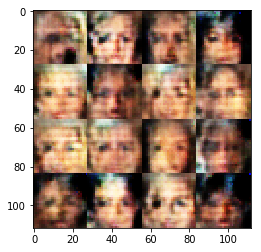

Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 2.8094
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 2.0889
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 0.7110... Generator Loss: 4.3721
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 1.7720
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 2.8685
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 0.6202... Generator Loss: 2.9911
Epoch 1/1... Discriminator Loss: 1.8084... Generator Loss: 0.6926


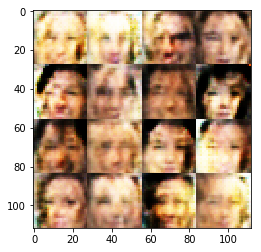

Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.7263
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 3.0097
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 2.2948
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 1.3514
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 2.3343
Epoch 1/1... Discriminator Loss: 1.5615... Generator Loss: 1.2996
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 1.9783
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.4233


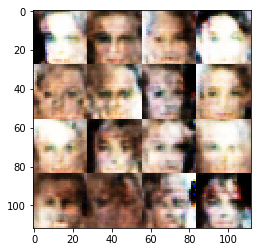

Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 2.5066
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.7241
Epoch 1/1... Discriminator Loss: 0.5155... Generator Loss: 3.6970
Epoch 1/1... Discriminator Loss: 1.9117... Generator Loss: 3.4701
Epoch 1/1... Discriminator Loss: 1.6155... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 0.7898... Generator Loss: 2.3030
Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 2.1509
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 2.8306
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.6390


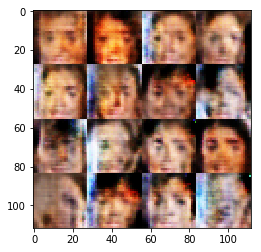

Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 1.9571
Epoch 1/1... Discriminator Loss: 3.1405... Generator Loss: 3.4798
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 2.0108
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 2.9387
Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 2.2458
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.9555
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 2.4611
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 3.1501


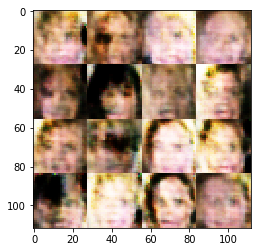

Epoch 1/1... Discriminator Loss: 0.5947... Generator Loss: 2.3911
Epoch 1/1... Discriminator Loss: 1.5881... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 0.4626... Generator Loss: 2.9736
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.5870... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.8129... Generator Loss: 0.3806
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 1.1664


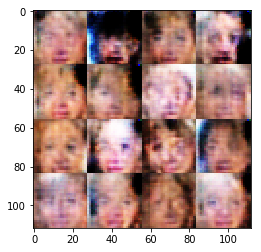

Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.7653... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 2.8572... Generator Loss: 3.9115
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 1.5989
Epoch 1/1... Discriminator Loss: 2.2131... Generator Loss: 0.3138
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.0512
Epoch 1/1... Discriminator Loss: 1.6356... Generator Loss: 0.4777


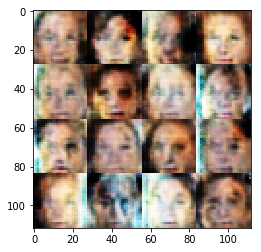

Epoch 1/1... Discriminator Loss: 1.6465... Generator Loss: 2.0070
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 2.0606
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 3.1225
Epoch 1/1... Discriminator Loss: 0.8406... Generator Loss: 1.7726
Epoch 1/1... Discriminator Loss: 1.8106... Generator Loss: 2.6399
Epoch 1/1... Discriminator Loss: 2.2050... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 1.8865
Epoch 1/1... Discriminator Loss: 0.6845... Generator Loss: 1.2957
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 2.2675
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 2.4157


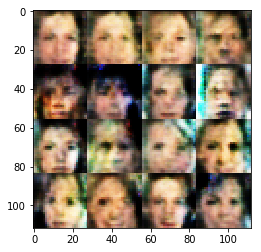

Epoch 1/1... Discriminator Loss: 1.8438... Generator Loss: 2.4101
Epoch 1/1... Discriminator Loss: 2.2347... Generator Loss: 3.0896
Epoch 1/1... Discriminator Loss: 2.1085... Generator Loss: 0.4242
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 1.3140
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 1.7097
Epoch 1/1... Discriminator Loss: 0.7952... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 2.2921
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 1.6384... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.9999... Generator Loss: 0.5438


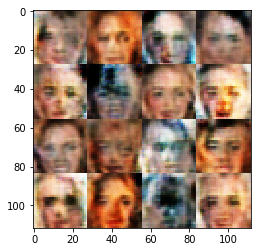

Epoch 1/1... Discriminator Loss: 2.7565... Generator Loss: 3.1650
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 1.7304
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 3.2126
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 3.2214
Epoch 1/1... Discriminator Loss: 2.4966... Generator Loss: 0.3998
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 2.3308
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.1821


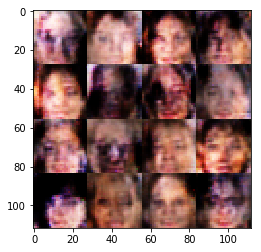

Epoch 1/1... Discriminator Loss: 0.5840... Generator Loss: 2.4233
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 1.4469
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 2.0759
Epoch 1/1... Discriminator Loss: 1.8644... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 1.6106... Generator Loss: 2.8151
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 2.0296
Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 3.3517
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 2.6580
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 2.9168


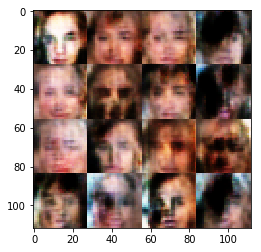

Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.8944... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 1.5435
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 1.4419
Epoch 1/1... Discriminator Loss: 2.2773... Generator Loss: 0.3670
Epoch 1/1... Discriminator Loss: 0.6031... Generator Loss: 3.5084
Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 1.4234
Epoch 1/1... Discriminator Loss: 0.6784... Generator Loss: 1.3463
Epoch 1/1... Discriminator Loss: 0.6379... Generator Loss: 1.6519


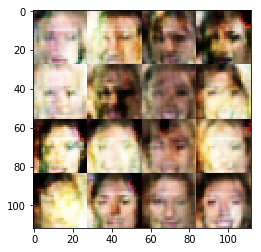

Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 1.7497
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 2.8272
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 2.5482
Epoch 1/1... Discriminator Loss: 0.8385... Generator Loss: 3.2306
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 1.1840
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 1.6442
Epoch 1/1... Discriminator Loss: 0.6027... Generator Loss: 1.8738
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 1.5743
Epoch 1/1... Discriminator Loss: 2.1323... Generator Loss: 0.5457


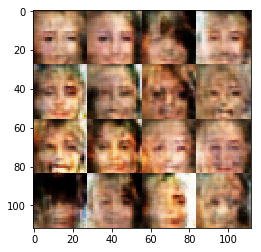

Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 4.0008
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 2.2165
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 2.4418
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.2448
Epoch 1/1... Discriminator Loss: 1.5586... Generator Loss: 2.1182
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 1.2330


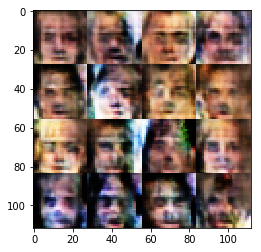

Epoch 1/1... Discriminator Loss: 0.7791... Generator Loss: 1.6012
Epoch 1/1... Discriminator Loss: 0.7505... Generator Loss: 1.6680
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 1.4608
Epoch 1/1... Discriminator Loss: 0.6043... Generator Loss: 2.3405
Epoch 1/1... Discriminator Loss: 2.2782... Generator Loss: 2.6506
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 1.4052
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 0.5705... Generator Loss: 3.2859
Epoch 1/1... Discriminator Loss: 0.6320... Generator Loss: 2.7382


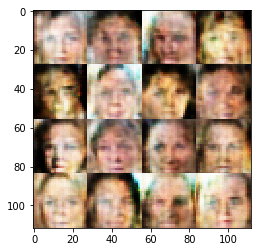

Epoch 1/1... Discriminator Loss: 0.7038... Generator Loss: 2.1191
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 1.3227
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 2.4466
Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.8229
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 1.4364
Epoch 1/1... Discriminator Loss: 0.4594... Generator Loss: 2.7624
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 2.1905


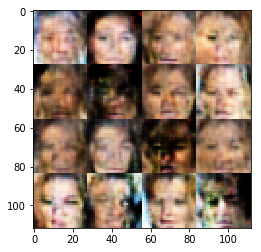

Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 1.7309
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 1.4469
Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.3309
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 1.0063
Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 1.6826
Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 1.8035
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 1.0357


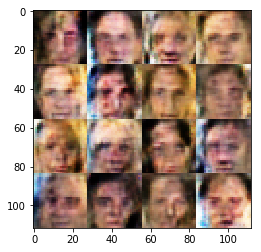

Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 1.7078
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 2.0462
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 1.1723
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 2.6972
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 1.4044
Epoch 1/1... Discriminator Loss: 1.7147... Generator Loss: 3.4567
Epoch 1/1... Discriminator Loss: 0.6313... Generator Loss: 1.8085
Epoch 1/1... Discriminator Loss: 1.5721... Generator Loss: 0.5677


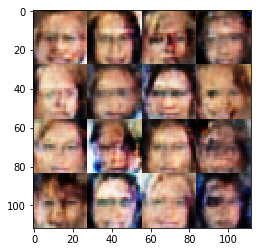

Epoch 1/1... Discriminator Loss: 0.6204... Generator Loss: 1.3135
Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 2.4079
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 2.9132
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 1.5846
Epoch 1/1... Discriminator Loss: 2.7671... Generator Loss: 0.1680
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 1.6129
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.2199
Epoch 1/1... Discriminator Loss: 1.7291... Generator Loss: 3.0794


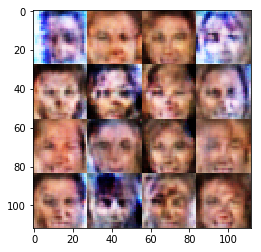

Epoch 1/1... Discriminator Loss: 0.6884... Generator Loss: 1.6850
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 1.2124
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 2.0976
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 2.5892
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 1.4206
Epoch 1/1... Discriminator Loss: 0.7638... Generator Loss: 1.5673
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 1.3119
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.7327


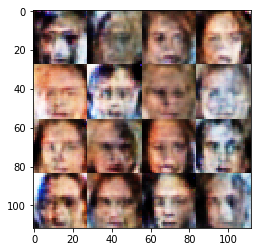

Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.1497
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 1.2808
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.6077
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 3.5198
Epoch 1/1... Discriminator Loss: 0.6377... Generator Loss: 2.1309
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 1.8802
Epoch 1/1... Discriminator Loss: 0.6988... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 3.2732
Epoch 1/1... Discriminator Loss: 0.8109... Generator Loss: 1.5389
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 1.4212


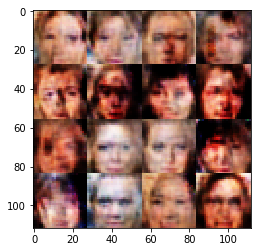

Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.5448
Epoch 1/1... Discriminator Loss: 1.6835... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 2.4212
Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 2.0324
Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 1.4274
Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 1.4207
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 2.2922
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 1.1809


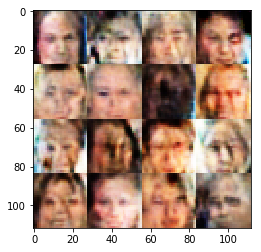

Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 1.2060
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 1.7446
Epoch 1/1... Discriminator Loss: 0.6111... Generator Loss: 3.3004
Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 1.9917
Epoch 1/1... Discriminator Loss: 1.9134... Generator Loss: 2.0775
Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 2.0166
Epoch 1/1... Discriminator Loss: 0.8642... Generator Loss: 1.6872
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 2.9278


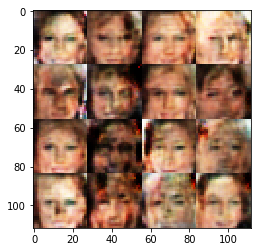

Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 2.7080
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 1.8477
Epoch 1/1... Discriminator Loss: 0.4669... Generator Loss: 4.0155
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.2082
Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 2.3886
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 1.6817
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.2808


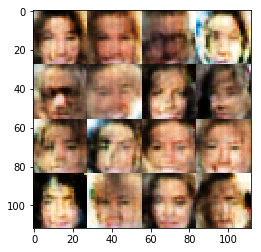

Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 1.5502
Epoch 1/1... Discriminator Loss: 0.7143... Generator Loss: 1.4585
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.3782
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.3650
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 2.0188
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 2.1337... Generator Loss: 3.0556
Epoch 1/1... Discriminator Loss: 0.6551... Generator Loss: 2.1296
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 2.1977


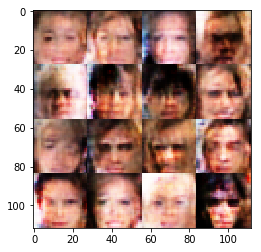

Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 2.1023
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 2.3119
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 1.8463
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.8080... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 0.5197... Generator Loss: 2.3401


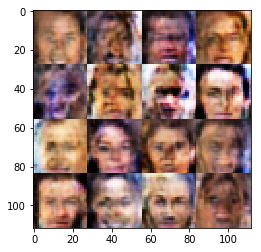

Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 2.0196
Epoch 1/1... Discriminator Loss: 1.9243... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.3460
Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 3.3486
Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 1.7190
Epoch 1/1... Discriminator Loss: 0.7913... Generator Loss: 1.2389
Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 1.1963
Epoch 1/1... Discriminator Loss: 0.8494... Generator Loss: 2.8177
Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 2.0384


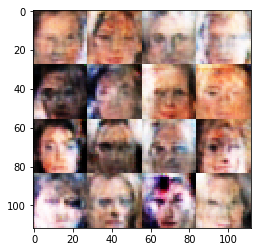

Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 2.2517
Epoch 1/1... Discriminator Loss: 0.7189... Generator Loss: 1.8652
Epoch 1/1... Discriminator Loss: 0.8118... Generator Loss: 1.4677
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 2.4010
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.6929... Generator Loss: 0.4975
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 1.2446
Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 2.0621
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 2.3434
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.4699


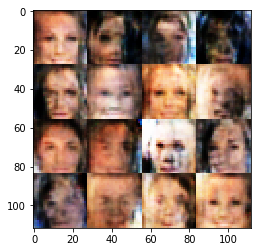

Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 2.1590
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 1.5139
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 0.6623... Generator Loss: 1.6701
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.9129
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 1.7850
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.9803
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 2.4166
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 1.1041


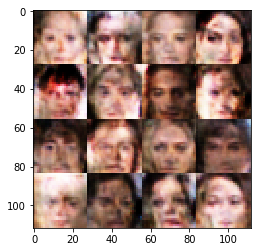

Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 2.1544
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.6055
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 2.8923... Generator Loss: 2.6751
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 1.3614
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 1.4872
Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 1.8327


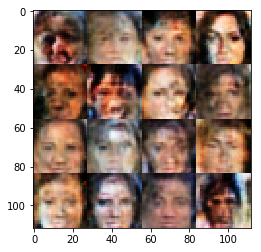

Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 1.5496
Epoch 1/1... Discriminator Loss: 0.6813... Generator Loss: 2.6313
Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 1.5755
Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 1.5263
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 1.6653
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 1.5969
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 0.6009... Generator Loss: 2.5019
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 2.5285


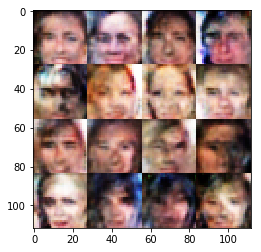

Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.9631
Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 1.5470
Epoch 1/1... Discriminator Loss: 1.9090... Generator Loss: 0.3883
Epoch 1/1... Discriminator Loss: 0.6001... Generator Loss: 2.1611
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.5269
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 2.2443
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 1.8204
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 2.2649
Epoch 1/1... Discriminator Loss: 2.3541... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.6316


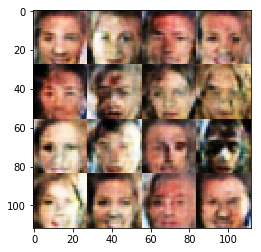

Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 1.2696
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.3635
Epoch 1/1... Discriminator Loss: 0.6023... Generator Loss: 2.3756
Epoch 1/1... Discriminator Loss: 0.8349... Generator Loss: 1.3147
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 1.3586
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 1.7731
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.3829


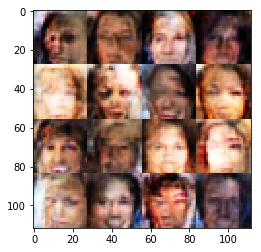

Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 1.5776... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.1396
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.4598
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 1.5334
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 1.0850


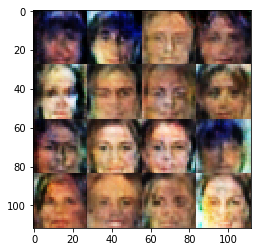

Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 1.5057
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.5626
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 1.3141
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.4753
Epoch 1/1... Discriminator Loss: 0.7994... Generator Loss: 1.9253
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 1.7425
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 1.8422
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 1.2367
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 2.7980
Epoch 1/1... Discriminator Loss: 0.5414... Generator Loss: 1.9634


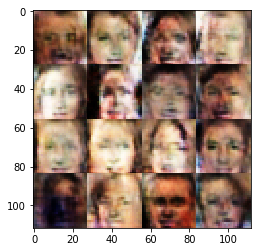

Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 1.4700
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.4470
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 1.4814
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 1.6674
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.1818
Epoch 1/1... Discriminator Loss: 0.5673... Generator Loss: 1.6889
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 2.1872


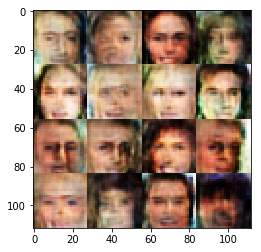

Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 1.5999
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 2.3730
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.4496
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.5285
Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 1.6564
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.2190
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 0.7458... Generator Loss: 1.6987


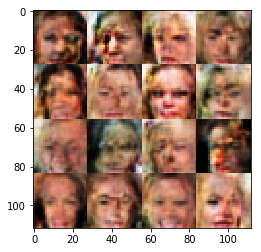

Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.9104
Epoch 1/1... Discriminator Loss: 0.6211... Generator Loss: 1.7846
Epoch 1/1... Discriminator Loss: 0.6111... Generator Loss: 2.7081
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.6952... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 1.7102... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 1.9465
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 3.2999
Epoch 1/1... Discriminator Loss: 1.7815... Generator Loss: 0.3500


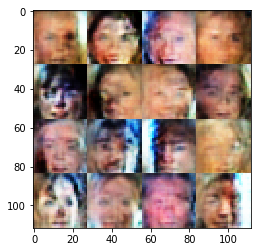

Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.3666
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 1.2728
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 1.6782
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 1.7492
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 1.1123
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 1.4407
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 1.4461
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 2.2348


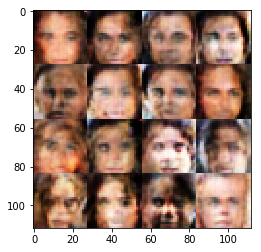

Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.6006
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.8048... Generator Loss: 0.3750
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.7860... Generator Loss: 0.3947
Epoch 1/1... Discriminator Loss: 0.7237... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 1.0050


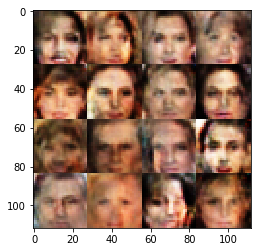

Epoch 1/1... Discriminator Loss: 2.1065... Generator Loss: 0.4351
Epoch 1/1... Discriminator Loss: 2.4495... Generator Loss: 2.0112
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.1742
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 2.4897... Generator Loss: 2.8455
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.3711
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.9514


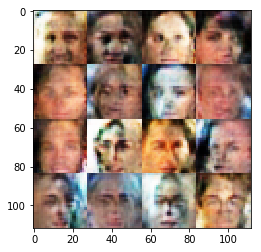

Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.3167
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 1.0719
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 1.1047
Epoch 1/1... Discriminator Loss: 1.9591... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.5355
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.5798
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 0.7397... Generator Loss: 1.5324
Epoch 1/1... Discriminator Loss: 0.4920... Generator Loss: 3.1563


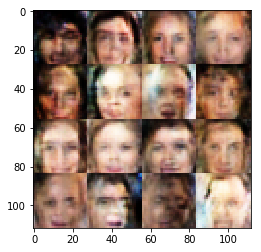

Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 2.5274
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 1.2424
Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 2.3102
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 2.8439
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.6887... Generator Loss: 0.3595
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.5316
Epoch 1/1... Discriminator Loss: 0.7974... Generator Loss: 1.3061


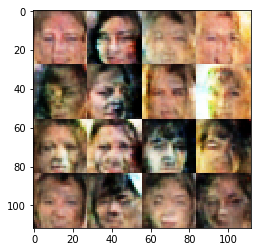

Epoch 1/1... Discriminator Loss: 0.7147... Generator Loss: 1.7681
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 1.1614
Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 1.8442
Epoch 1/1... Discriminator Loss: 2.0149... Generator Loss: 2.8361
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 2.5703
Epoch 1/1... Discriminator Loss: 0.6391... Generator Loss: 2.3418
Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.8931
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 3.1118
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 2.3021


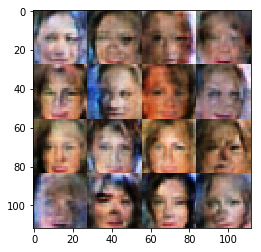

Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 1.4415
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.6479
Epoch 1/1... Discriminator Loss: 1.6728... Generator Loss: 1.2611
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 1.2905
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 1.2316
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 1.6827


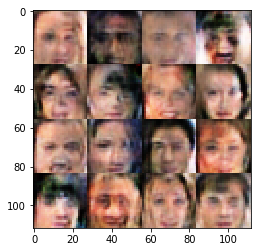

Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 1.2423
Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 1.5457
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 1.1654
Epoch 1/1... Discriminator Loss: 1.8029... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 1.4310
Epoch 1/1... Discriminator Loss: 1.8706... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.2272
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 1.2599
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.9688


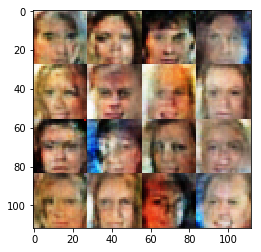

Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 1.1471
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 1.6824
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 0.6957... Generator Loss: 2.2252
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 1.7457
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 1.8792
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 2.1100
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 1.1123


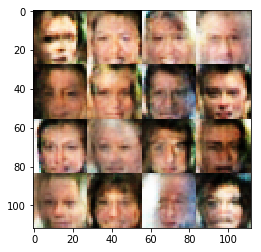

Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.9422
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 1.0067
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.5781
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.2081


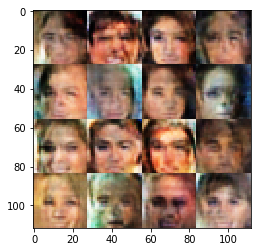

Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.5835
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 1.6715
Epoch 1/1... Discriminator Loss: 1.6082... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 1.4155
Epoch 1/1... Discriminator Loss: 0.6227... Generator Loss: 1.3948
Epoch 1/1... Discriminator Loss: 0.6485... Generator Loss: 1.5940
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 1.2910
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 1.4732
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 1.6048


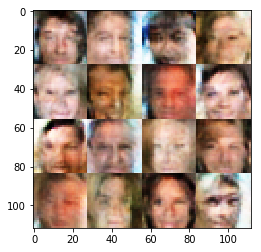

Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 1.5076
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 2.1676
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 1.3573
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 2.0021
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.5541
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 1.4343
Epoch 1/1... Discriminator Loss: 0.8144... Generator Loss: 1.5155


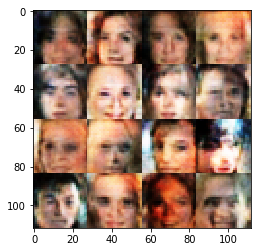

Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.3655
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 1.2886
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.4578
Epoch 1/1... Discriminator Loss: 1.8062... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 0.8924


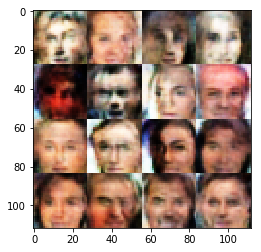

Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.9406
Epoch 1/1... Discriminator Loss: 1.7256... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.1149
Epoch 1/1... Discriminator Loss: 0.7078... Generator Loss: 1.4132
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 1.7129
Epoch 1/1... Discriminator Loss: 1.5990... Generator Loss: 0.4199
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 1.0937
Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 1.9803
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.6883


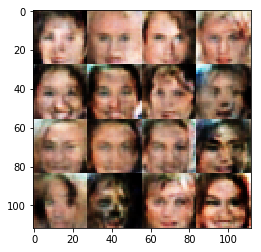

Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 3.0810
Epoch 1/1... Discriminator Loss: 1.7610... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 1.2868
Epoch 1/1... Discriminator Loss: 1.8126... Generator Loss: 2.3607
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.3772
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 1.4954
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 1.2145


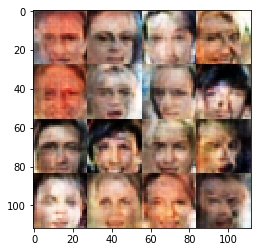

Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 1.0601
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 0.6303... Generator Loss: 1.7492
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 3.0579
Epoch 1/1... Discriminator Loss: 1.6114... Generator Loss: 0.4768
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 1.1155


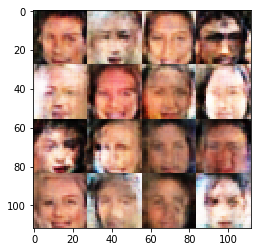

Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 1.5310
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 1.7791
Epoch 1/1... Discriminator Loss: 0.4683... Generator Loss: 2.4555
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 2.0484
Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 1.2307
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 2.9787
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 2.0324
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 2.2409


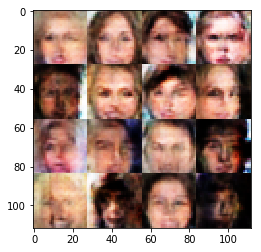

Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.3445
Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 1.6029
Epoch 1/1... Discriminator Loss: 2.6780... Generator Loss: 0.4164
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.3787
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.8594
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 1.4977
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 1.0673
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.6414


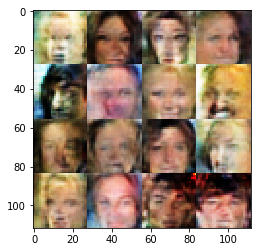

Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.7298
Epoch 1/1... Discriminator Loss: 1.6655... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.6516... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.8631... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 1.1100
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 1.6072
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 1.5041
Epoch 1/1... Discriminator Loss: 1.7016... Generator Loss: 1.2380


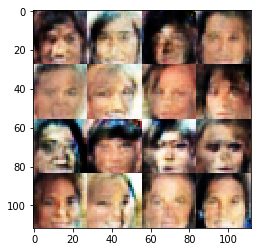

Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.8421... Generator Loss: 0.3554
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 1.4174
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 1.3334
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 1.0550
Epoch 1/1... Discriminator Loss: 1.5823... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 1.4408
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.1084


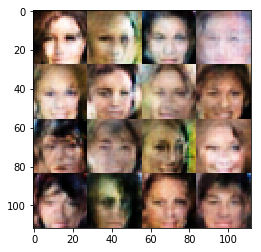

Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 1.1738
Epoch 1/1... Discriminator Loss: 1.5961... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 1.7101
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 1.4803
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.5706... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.7648... Generator Loss: 2.4136


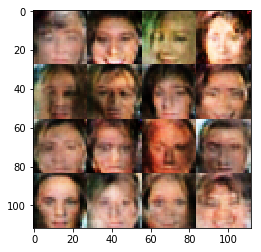

Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 1.1909
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 1.2646
Epoch 1/1... Discriminator Loss: 1.5936... Generator Loss: 2.4176
Epoch 1/1... Discriminator Loss: 1.6797... Generator Loss: 2.6269
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 1.2533
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 1.3618
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.6812


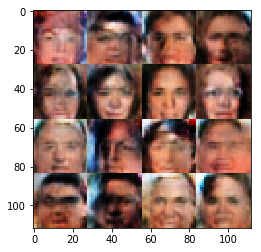

Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.0865
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 1.7689
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 1.2230
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 1.2858
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 1.7967
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 1.0402
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 1.1905


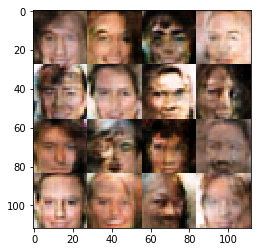

Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 0.6282... Generator Loss: 1.8111
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 1.6360
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 1.0069


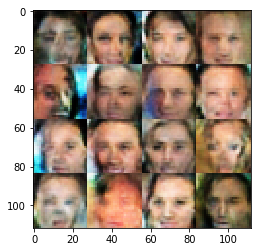

Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 1.7462
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 2.3152
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 2.2885
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 1.3025
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 1.1836


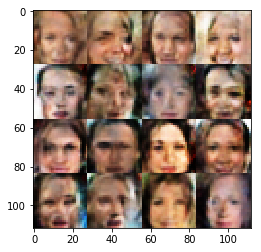

Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 1.2457
Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 2.0726
Epoch 1/1... Discriminator Loss: 0.4765... Generator Loss: 2.3725
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 1.7238
Epoch 1/1... Discriminator Loss: 0.5144... Generator Loss: 2.3254
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.9126


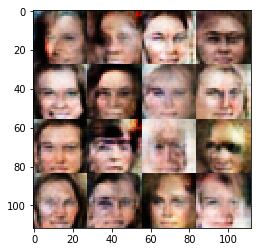

Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.1607
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 1.0397
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.7024
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 1.0989
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 1.2292
Epoch 1/1... Discriminator Loss: 0.7261... Generator Loss: 1.5511
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.3838


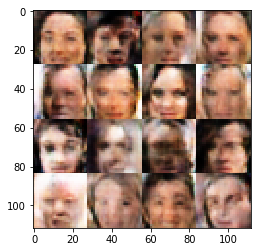

Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 1.3197
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.5185
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 1.2115
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 1.1863
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.9131


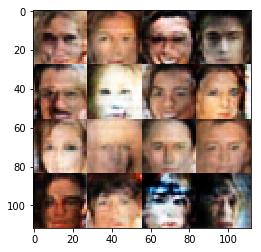

Epoch 1/1... Discriminator Loss: 1.7552... Generator Loss: 0.3488
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 1.4061
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 2.5029
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.4527
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 2.5138
Epoch 1/1... Discriminator Loss: 0.5135... Generator Loss: 1.9222
Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 2.0100
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.7558
Epoch 1/1... Discriminator Loss: 0.7672... Generator Loss: 1.9149


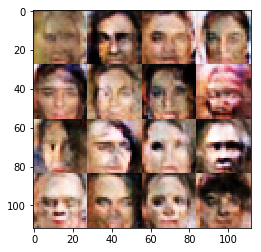

Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 1.6598
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 1.4067
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.6120
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 1.7387
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.9260


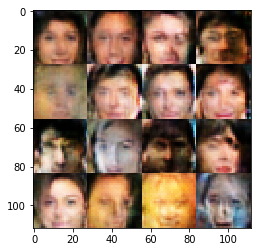

Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 1.2285
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 2.4821
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 1.6707
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 1.9139
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 1.1006
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 1.0118


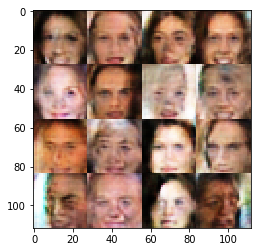

Epoch 1/1... Discriminator Loss: 1.6554... Generator Loss: 1.0299
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 1.3876


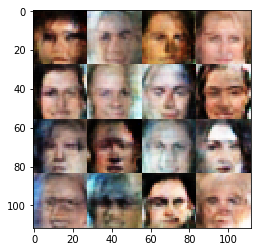

Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 1.0770
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 1.2136
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.6100... Generator Loss: 0.9866


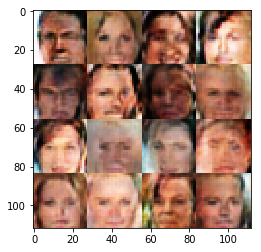

Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 1.2387
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 1.1615
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 0.6076... Generator Loss: 1.7779
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 1.1548
Epoch 1/1... Discriminator Loss: 1.7301... Generator Loss: 2.2376
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.3049


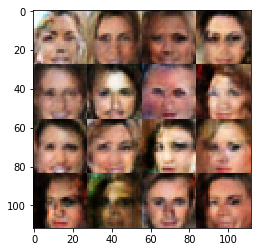

Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 1.0262
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.4682
Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.4929
Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 1.4963
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 1.2041


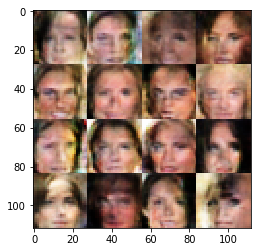

Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 1.4473
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 1.4575
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 1.1637
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 1.1821
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 1.3688


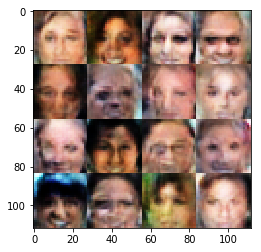

Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 1.3711
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 1.1065
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 1.3849
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 1.4916
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 2.8079
Epoch 1/1... Discriminator Loss: 0.5118... Generator Loss: 2.8530
Epoch 1/1... Discriminator Loss: 3.0699... Generator Loss: 0.2749


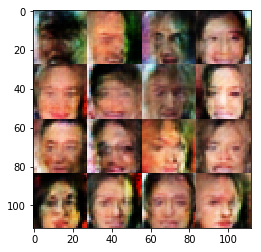

Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 1.7708... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 0.6155... Generator Loss: 1.5169
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 1.1128
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 1.3249
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 1.1771
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 1.1440
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.8622


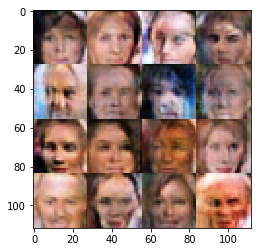

Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 1.0488
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 2.0297


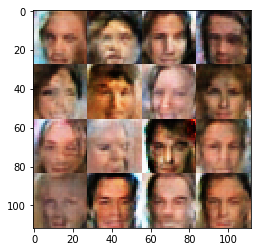

Epoch 1/1... Discriminator Loss: 1.7453... Generator Loss: 2.2224
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 1.3529
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 1.2746
Epoch 1/1... Discriminator Loss: 0.6954... Generator Loss: 1.2225
Epoch 1/1... Discriminator Loss: 0.6076... Generator Loss: 1.7198
Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 3.1186
Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 1.5596
Epoch 1/1... Discriminator Loss: 1.7680... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 1.2870


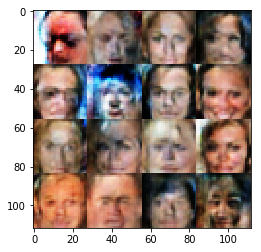

Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.0968
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 1.3381
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 1.7802
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 1.2454
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 1.0979
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.1586
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 1.2723


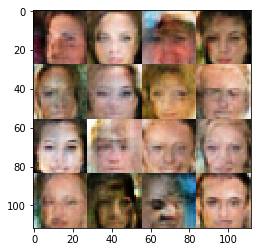

Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 2.0853
Epoch 1/1... Discriminator Loss: 0.6618... Generator Loss: 1.5427
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 2.9254
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 1.2208
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 1.4997
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 1.5080
Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 0.9861


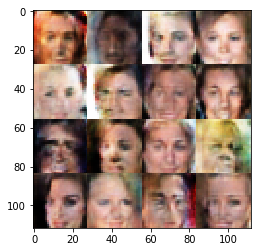

Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 1.0660
Epoch 1/1... Discriminator Loss: 0.6688... Generator Loss: 1.4511
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.9089
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.9206


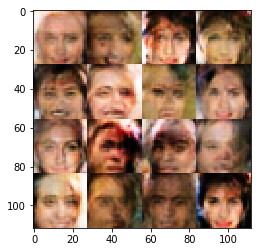

Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 1.2220
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 1.1474
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.6769


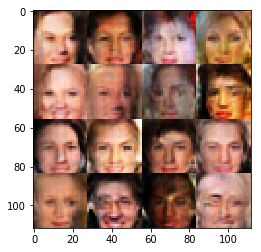

Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.7195... Generator Loss: 1.4876
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 1.2523
Epoch 1/1... Discriminator Loss: 1.6028... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 1.4665
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 1.1049


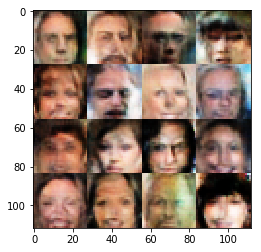

Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 1.3132
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 1.1216
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 1.0955
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.7404


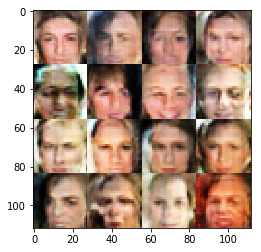

Epoch 1/1... Discriminator Loss: 0.6763... Generator Loss: 2.0263
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 1.4827
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 1.1424
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.2153
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.8459


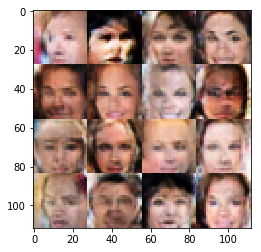

Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 1.1814
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 1.1511
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 1.6028
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.8876


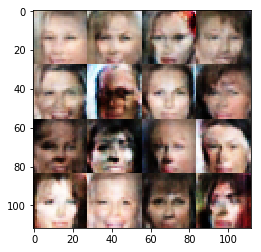

Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 2.2961
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.9904
Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 1.5908
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 2.8703
Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 2.7137
Epoch 1/1... Discriminator Loss: 0.4674... Generator Loss: 2.6667
Epoch 1/1... Discriminator Loss: 0.7289... Generator Loss: 2.0260
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 2.5500
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 1.4911


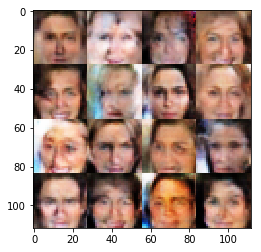

Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.0570
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 1.6852
Epoch 1/1... Discriminator Loss: 0.5470... Generator Loss: 1.8904
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 1.4930
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 1.9492
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 1.0104
Epoch 1/1... Discriminator Loss: 0.4205... Generator Loss: 2.7337
Epoch 1/1... Discriminator Loss: 0.5042... Generator Loss: 2.4478


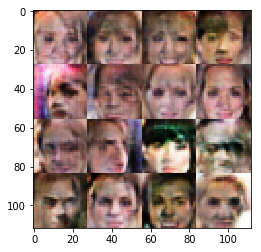

Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 2.7028
Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 0.9970
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 1.7130
Epoch 1/1... Discriminator Loss: 1.8364... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 0.4592... Generator Loss: 3.2152
Epoch 1/1... Discriminator Loss: 0.5498... Generator Loss: 2.3266
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 1.0943
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.9857


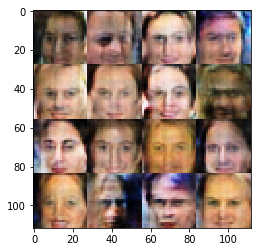

Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 1.4491
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 2.1332
Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 1.5243
Epoch 1/1... Discriminator Loss: 0.6587... Generator Loss: 1.4572
Epoch 1/1... Discriminator Loss: 0.4434... Generator Loss: 3.2680
Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 2.5133
Epoch 1/1... Discriminator Loss: 0.7095... Generator Loss: 1.6474
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 2.7808
Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.7018


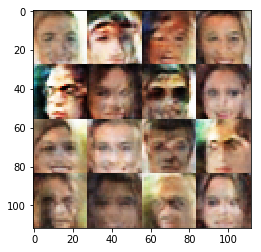

Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 1.2935
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 1.5195
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.2743


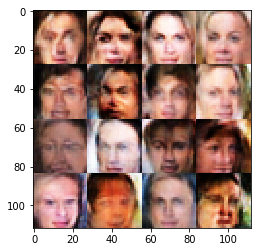

Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 1.1584
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 1.2924
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 1.5815
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 1.6782
Epoch 1/1... Discriminator Loss: 0.4714... Generator Loss: 2.6161
Epoch 1/1... Discriminator Loss: 0.7351... Generator Loss: 3.2012
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 0.6294... Generator Loss: 2.4250


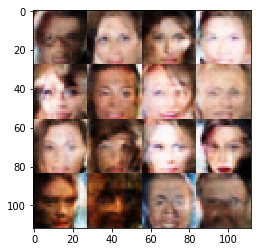

Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 1.4848
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 1.7457
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 0.5409... Generator Loss: 2.6969
Epoch 1/1... Discriminator Loss: 0.5596... Generator Loss: 2.1181
Epoch 1/1... Discriminator Loss: 0.6306... Generator Loss: 1.5674
Epoch 1/1... Discriminator Loss: 0.4496... Generator Loss: 3.0204
Epoch 1/1... Discriminator Loss: 1.8160... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.6788... Generator Loss: 0.5397


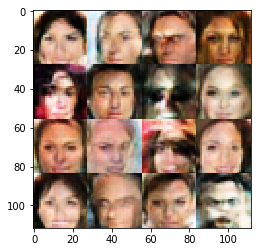

Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 1.7366
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 1.0571
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 1.2609
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.4865
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 1.1900
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 1.4498
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 1.2207


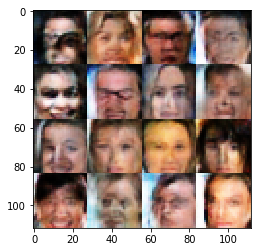

Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.4465
Epoch 1/1... Discriminator Loss: 0.5876... Generator Loss: 2.0595
Epoch 1/1... Discriminator Loss: 0.7733... Generator Loss: 1.8195
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.9766


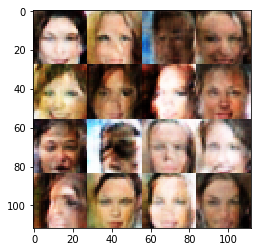

Done


In [ ]:
batch_size = 16
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.